# XGBoost - Credit score

## Method

### XGBoost
XGBoost, short for eXtreme Gradient Boosting, is to fit a series of weak learners, often decision trees, to the residuals of the previous model.

- Given a dataset $\{ x^{(i)}, y^{(i)} \}^{n}_{i=1}$ and the prediction $y^{(i)}$ is initialised to be 0.5

- At the stage $m \in \{1, 2, ..., M\}$, the objective function is $$\begin{align*}L_{m}&= \sum\limits_{i=1}^{n} L(y^{(i)}, \hat{y}^{(i)}_{m-1}+f_{m}(x^{(i)})) + \Omega(f_{m}) \\ &= \sum\limits_{i=1}^{n} L(y^{(i)}, \hat{y}^{(i)}_{m-1}+f_{m}(x^{(i)})) + \gamma T + \frac{1}{2}\lambda \sum\limits_{t=1}^{T} w_{t}^{2} \end{align*}$$
	- $L$ is the loss function
		- It represents the training loss measuring how well model fit on training data, and can be interpreted as bias reduction
		- For classification: log loss will be used
		- For regression: squared loss function will used
	- $y^{(i)}$ is the true label for the $i^{th}$ instance
	- $\hat{y}_{m-1}^{(i)}$ is the predicted value for the $i^{th}$ instance at iteration $(m-1)$
	- $f_{m}(x^{(i)})$ is the output of the $m^{th}$ weak tree / base learner for the $i^{th}$ instance
		- i.e. minimise residual iteratively
	- $\Omega(f_{m})$ is the regularization term penalising the complexity of the tree and can be interpreted as variance reduction
	- $T$ is the number of leaves in the $f_{m}$
	- $w_{t}$ is the output / prediction for leaf node $t$ of $f_{m}$
	- $\gamma$ and $\lambda$ are regularisation parameters

- By Taylor expansion, the object function can be approximated by $$L_{m}\approx \sum\limits_{i=1}^{n}\left[L(y^{(i)}, \hat{y}_{m-1}^{(i)})+g_{i}f_{m}(x^{(i)})+\frac{1}{2} h_{i}f_{m}^{2}(x^{(i)})\right]+\Omega(f_{m})$$
	- $g_{i} = \frac{\partial L(y^{(i)}, \hat{y}^{(i)}_{m-1})}{\partial \hat{y}^{(i)}_{m-1}}$
	- $h_{i} = \frac{\partial^{2} L(y^{(i)}, \hat{y}^{(i)}_{m-1})}{\partial (\hat{y}^{(i)}_{m-1})^{2}}$
	- For regression, $g_i=-(y^{(i)} - \hat{y}_{m-1}^{(i)})$ and $h_{i} = 1$
		- $\hat{y}_{m-1}^{(i)}$ is the previous probability for $i^{th}$ instance
	- For classification, $g_{i}=-(y_{i}-\hat{y}_{m-1}^{(i)})$ and $h_{i}=\hat{y}_{m-1}^{(i)} \times (1-\hat{y}_{m-1}^{(i)})$

- Remove the constants in the objective function $$\widetilde{L}_{m} = \sum\limits_{i=1}^{n} \left[g_{i}f_{m}(x^{(i)}) + \frac{1}{2} h_{i} f_{m}^{2}(x^{(i)})\right] + \Omega(f_{m})$$
	- Since $\hat{y}_{m-1}^{(i)}$ can be obtained from previous iteration, $L(y^{(i)}, \hat{y}_{m-1}^{(i)})$ is known
- Rewrite the objective function $$\begin{align*} \widetilde{L}_{m} &= \sum\limits_{i=1}^{n} \left[g_{i}f_{m}(x^{(i)}) + \frac{1}{2} h_{i} f_{m}^{2}(x^{(i)})\right] + \left[ \gamma T + \frac{1}{2}\lambda \sum\limits_{t=1}^{T} w_{t}^{2} \right] \\ &= \sum\limits_{t=1}^{T} \left[\left(\sum\limits_{i \in I_{t}}g_{i}\right)w_{t} + \frac{1}{2}\left( \sum\limits_{i \in I_{t}} h_{i} + \lambda \right) w_{t}^{2} \right] + \gamma T \end{align*}$$
	- Partition the dataset into disjoint leaf nodes and group the instances to $I_{t}$, the set of instance belonging to leaf node $t$ of the tree $f_{m}$
	- Recall: $w_{t}$ is the output / prediction for leaf node $t$ of $f_{m}$
	- This is a sum of $T$ independent quadratic functions
- The objective function is minimised when $$ w^{*}_{t} =- \frac{\sum\limits_{i \in I_{t}}g_{i}}{\sum\limits_{i \in I_{t}}h_{i} + \lambda}$$
	- The second derivative of $\widetilde{L}_{m}$ is positive
	- For regression, $\frac{\text{sum of residual}}{\text{Number of residual} + \lambda}$
	- For classification,  $\frac{\text{sum of residual}}{\text{sum of (previous probability * (1- previous probability))}+\lambda}$
- The minimised objective function is  $$\widetilde{L}^{*}_{m} = -\frac{1}{2} \sum\limits_{t=1}^{T} \frac{( \sum\limits_{i \in I_{t}} g_{i} )^{2}}{\sum\limits_{i \in I_{t}} h_{i} + \lambda} + \gamma T$$
- There are infinitely many ways to build the tree to achieve the optimal value of the objective function, so we build it greedily and select the one with largest loss reduction after split i.e. gain
- For each leaf node $t$, the loss reduction after the split into nodes $L$ and $R$ is $$\widetilde{L}_{split} =  \frac{1}{2} \left[\frac{(\sum\limits_{i \in I_{L}}g_{i})^{2}}{\sum\limits_{i \in I_{L}}h_{i} + \lambda} + \frac{(\sum\limits_{i \in I_{R}}g_{i})^{2}}{\sum\limits_{i \in I_{R}}h_{i} + \lambda} - \frac{(\sum\limits_{i \in I_{L}}g_{i} + \sum\limits_{i \in I_{R}}g_{i})^{2}}{\sum\limits_{i \in I_{L}}h_{i} + \sum\limits_{i \in I_{R}}h_{i} + \lambda} \right] -\gamma$$
	- The loss reduction = loss function without split - total loss function with split
- Ignore the constant $$\text{Gain} = \frac{(\sum\limits_{i \in I_{L}}g_{i})^{2}}{\sum\limits_{i \in I_{L}}h_{i} + \lambda} + \frac{(\sum\limits_{i \in I_{R}}g_{i})^{2}}{\sum\limits_{i \in I_{R}}h_{i} + \lambda} - \frac{(\sum\limits_{i \in I_{L}}g_{i} + \sum\limits_{i \in I_{R}}g_{i})^{2}}{\sum\limits_{i \in I_{L}}h_{i} + \sum\limits_{i \in I_{R}}h_{i} + \lambda} - \gamma$$
- Update the predicted value $$\hat{y}_{m}^{(i)} = \hat{y}_{m-1}^{(i)} + \eta f_{m}(x^{(i)})$$
	- $\eta$ is the learning rate
- The final prediction is obtained by summing the predictions of all trees $$\hat{y}^{(i)} = \hat{y}_{M}^{(i)} $$











### Imbalanced dataset
**Concept**
* It refers to a situation in a classification problem where the distribution of target classes is not equal. In other words, one class (the minority class) has significantly fewer instances than another class (the majority class) 

**Solution** 

In accordance with the recommendations provided in the XGBoost documentation, if the primary concern is the overall performance metric of the prediction, 
* Balance the positive and negative weights via `scale_pos_weight`. A typical value to consider is [`sum(negative instances) / sum(positive instances)`](https://xgboost.readthedocs.io/en/latest/parameter.html)
* Use AUC for [evaluation](https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html#handle-imbalanced-dataset)

### Dataset
The following analysis is based on simulating data found from [Kaggle](https://www.kaggle.com/datasets/laotse/credit-risk-dataset/data). It consists of the following columns:
1. **person_age**: Age
2. **person_income**: Annual Income
3. **person_home_ownership**: Home ownership
4. **person_emp_length**: Employment length (in years)
5. **loan_intent**: Loan intent
6. **loan_grade**: Loan grade
7. **loan_amnt**: Loan amount
8. **loan_int_rate**: Interest rate
9. **loan_status**: Loan status (0 is non default 1 is default)
10. **loan_percent_income**: Percent income
11. **cb_person_default_on_file**: Historical default
12. **cb_preson_cred_hist_length**: Credit history length


## Result

In [7]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [8]:
# Import data
path_raw_data = "./data/credit_risk_dataset.csv"
df0 = pd.read_csv(path_raw_data)

### Data Checking

#### Dimension & Data type

In [9]:
# Check number of rows, columns and data type
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


#### Missing values

In [10]:
# Calculate the percentage of missing
df0.isnull().mean() * 100

person_age                    0.000000
person_income                 0.000000
person_home_ownership         0.000000
person_emp_length             2.747000
loan_intent                   0.000000
loan_grade                    0.000000
loan_amnt                     0.000000
loan_int_rate                 9.563856
loan_status                   0.000000
loan_percent_income           0.000000
cb_person_default_on_file     0.000000
cb_person_cred_hist_length    0.000000
dtype: float64

* Interest rate information is missing in 9.56% of all records, while 2.75% of records lack values for employment length.

#### Summary statistics

In [11]:
# Summary statistics for continuous variables 
df0.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [12]:
# Summary statistics for categorical variables 
df0.describe(include="object")

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
count,32581,32581,32581,32581
unique,4,6,7,2
top,RENT,EDUCATION,A,N
freq,16446,6453,10777,26836


#### Logical constraints

##### Age & Employment length & Credit history length

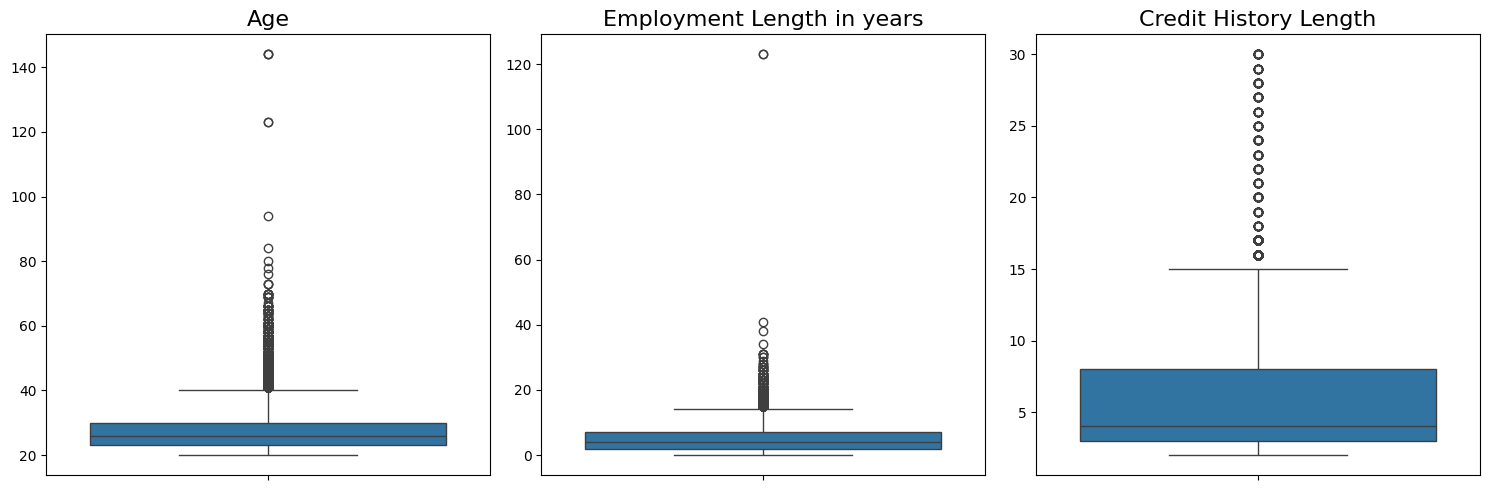

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(y='person_age', data=df0, ax=axes[0])
axes[0].set_title('Age', fontsize=16)
axes[0].set_ylabel('')
sns.boxplot(y='person_emp_length', data=df0, ax=axes[1])
axes[1].set_title('Employment Length in years', fontsize=16)
axes[1].set_ylabel('')
sns.boxplot(y='cb_person_cred_hist_length', data=df0, ax=axes[2])
axes[2].set_title('Credit History Length', fontsize=16)
axes[2].set_ylabel('')
plt.tight_layout()
plt.show()

##### Age

In [14]:
df0[df0.person_age>120]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
81,144,250000,RENT,4.0,VENTURE,C,4800,13.57,0,0.02,N,3
183,144,200000,MORTGAGE,4.0,EDUCATION,B,6000,11.86,0,0.03,N,2
575,123,80004,RENT,2.0,EDUCATION,B,20400,10.25,0,0.25,N,3
747,123,78000,RENT,7.0,VENTURE,B,20000,NaN,0,0.26,N,4
32297,144,6000000,MORTGAGE,12.0,PERSONAL,C,5000,12.73,0,0.00,N,25


* 5 out of 32,581 records (0.0153%) exhibit unusually high values, such as 123 and 144. Considering that the verified age of the oldest human is 122, any records indicating age greater than this maximum should be excluded

##### Employment length

In [15]:
df0[df0.person_emp_length > 120]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
210,21,192000,MORTGAGE,123.0,VENTURE,A,20000,6.54,0,0.10,N,4


* It is implausible for someone aged 21 or 22 to have accumulated 123 years of work experience
* Those records should be removed

In [16]:
df0["max_emp_length"] = df0.person_age - 16
df0["diff_emp_length"] = df0.max_emp_length - df0.person_emp_length
columns = ["person_age", "person_emp_length", "max_emp_length", "diff_emp_length"]
df0[columns]

,person_age,person_emp_length,max_emp_length,diff_emp_length
0,22,123.0,6,-117.0
1,21,5.0,5,0.0
2,25,1.0,9,8.0
3,23,4.0,7,3.0
4,24,8.0,8,0.0
...,...,...,...,...
32576,57,1.0,41,40.0
32577,54,4.0,38,34.0
32578,65,3.0,49,46.0
32579,56,5.0,40,35.0


In [17]:
columns = ["diff_emp_length"]
grouped_df = df0[columns].groupby(columns).size().reset_index(drop=False, name="n_record")
grouped_df["diff_emp_length_gp"] = grouped_df.diff_emp_length.apply(lambda x: ">0" if x > 0 else str(x))
grouped_df = grouped_df.drop(columns, axis=1).groupby("diff_emp_length_gp").sum()
grouped_df["percent_record"] = grouped_df["n_record"] / grouped_df["n_record"].sum() * 100
grouped_df

,n_record,percent_record
diff_emp_length_gp,,
-1.0,738,2.329104
-117.0,1,0.003156
-118.0,1,0.003156
0.0,5963,18.819037
>0,24983,78.845547


* Assume an individual is allowed to work once they reach the age of 16. 
* The maximum employment length `max_emp_length` would be `person_age` - 16
* It is expected that the difference in employment length `diff_emp_length` (= `max_emp_length` - `person_emp_length`) is greater than or equal to 0
* 2 records have a large difference i.e. -117 and -118, so they should be removed. 
* Approximately 2.33% of records show an employment length difference of -1. This discrepancy could be attributed to a rounding issue.

##### Credit history length

In [18]:
df0["max_cred_hist_length"] = df0.person_age - 18
df0["diff_cred_hist_length"] = df0.max_cred_hist_length - df0.cb_person_cred_hist_length
columns = ["person_age", "cb_person_cred_hist_length", "max_cred_hist_length", "diff_cred_hist_length"]
df0[columns]

,person_age,cb_person_cred_hist_length,max_cred_hist_length,diff_cred_hist_length
0,22,3,4,1
1,21,2,3,1
2,25,3,7,4
3,23,2,5,3
4,24,4,6,2
...,...,...,...,...
32576,57,30,39,9
32577,54,19,36,17
32578,65,28,47,19
32579,56,26,38,12


In [19]:
columns = ["diff_cred_hist_length"]
grouped_df = df0[columns].groupby(columns).size().reset_index(drop=False, name="n_record")
grouped_df["diff_cred_hist_length_gp"] = grouped_df.diff_cred_hist_length.apply(lambda x: ">0" if x > 0 else str(x))
grouped_df = grouped_df.drop(columns, axis=1).groupby("diff_cred_hist_length_gp").sum()
grouped_df["percent_record"] = grouped_df["n_record"] / grouped_df["n_record"].sum() * 100
grouped_df

,n_record,percent_record
diff_cred_hist_length_gp,,
-1,776,2.381756
-2,5,0.015346
0,2218,6.807649
>0,29582,90.795249


* Assume the credit account can be held from the age of 18 onwards
* The maximum credit history length `max_cred_hist_length` would be `person_age` - 18
* It is expected that the difference in credit history length `diff_cred_hist_length` (=`max_cred_hist_length`-`cb_person_cred_hist_length`) is greater than or equal to 0
* Approximately 2.4% of records show an employment length difference of -1 or -2. This discrepancy can be attributed to a rounding issue.

##### Income & Loan amount & Percentage of loan to income

In [20]:
df0["loan_percent_income2"] = df0["loan_amnt"] / df0["person_income"]
df0["diff_loan_percent_income"] = df0["loan_percent_income2"] - df0["loan_percent_income"]
columns = ["loan_amnt", "person_income", "loan_percent_income", "loan_percent_income2", "diff_loan_percent_income"]
rows = (df0.diff_loan_percent_income.abs() > 0.02)
df0[rows][columns].sort_values(by=["diff_loan_percent_income"], ascending=False)

,loan_amnt,person_income,loan_percent_income,loan_percent_income2,diff_loan_percent_income
4,35000,54400,0.55,0.643382,0.093382
11873,35000,60350,0.49,0.579950,0.089950
11253,30000,56403,0.45,0.531887,0.081887
13005,35000,63750,0.47,0.549020,0.079020
24150,27050,54400,0.42,0.497243,0.077243
...,...,...,...,...,...
20571,10000,76500,0.11,0.130719,0.020719
9460,8000,66300,0.10,0.120664,0.020664
12296,8825,62900,0.12,0.140302,0.020302
29090,10000,83300,0.10,0.120048,0.020048


* To figure out the formula of `loan_percent_income`, `loan_amnt` is divided by `person_income` and `loan_percent_income2` is calculated
* Approximately 0.9% of records (283 rows out of 32,581) exhibit differences greater than 0.02.
* The marginal variation observed cannot be attributed to rounding, as the rounding-induced difference is quite large e.g. 0.09
* Notably, the `loan_percent_income` is not derived through a simple division of `loan_amnt` by `person_income`.
* Given that the calculated `loan_percent_income` falls below the anticipated value, it suggests that the computation of this column may incorporate additional sources of income
* Should be careful to interpret the `loan_percent_income`

### Data Cleansing
1. Remove 5 records with `person_age` > 122
2. Remove 2 records with `person_emp_length` > 120

In [21]:
df0 = pd.read_csv(path_raw_data)
rows = (df0.person_age > 122) | (df0.person_emp_length > 120) 
df0 = df0[~rows]

In [22]:
print(f"Number of rows: {df0.shape[0]}")
print(f"Number of columns: {df0.shape[1]}")

Number of rows: 32574
Number of columns: 12


In [23]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32574 entries, 1 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32574 non-null  int64  
 1   person_income               32574 non-null  int64  
 2   person_home_ownership       32574 non-null  object 
 3   person_emp_length           31679 non-null  float64
 4   loan_intent                 32574 non-null  object 
 5   loan_grade                  32574 non-null  object 
 6   loan_amnt                   32574 non-null  int64  
 7   loan_int_rate               29459 non-null  float64
 8   loan_status                 32574 non-null  int64  
 9   loan_percent_income         32574 non-null  float64
 10  cb_person_default_on_file   32574 non-null  object 
 11  cb_person_cred_hist_length  32574 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.2+ MB


### Data Exploration

#### With target

##### Loan status

In [24]:
df0['loan_status'].value_counts()

loan_status
0    25467
1     7107
Name: count, dtype: int64

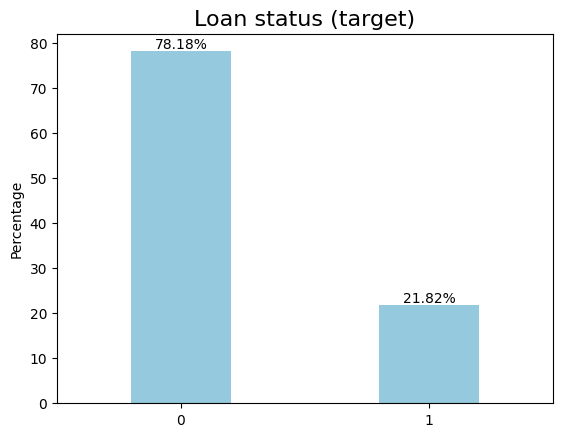

In [25]:
percentage_counts = df0['loan_status'].value_counts(normalize=True,dropna=False) * 100
ax = sns.barplot(x=percentage_counts.index, y=percentage_counts.values, width=0.4, color='skyblue')
plt.ylabel('Percentage')
plt.xlabel('')
plt.title('Loan status (target)', fontsize=16)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),textcoords='offset points')
plt.show()

* The dataset suffers from [mild](https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data) class imbalance (78.18% non-default, 21.82% default), which can lead to biased models favoring the majority class. 

##### Age & Employment length & Credit history length

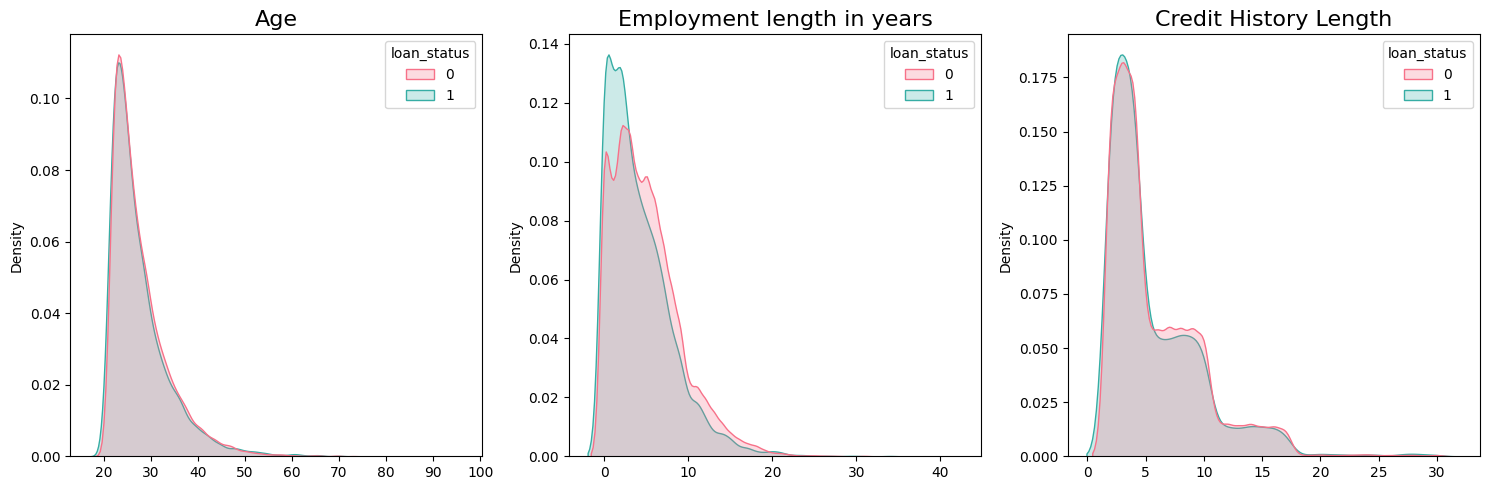

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.kdeplot(data=df0, x="person_age", hue="loan_status", fill=True, common_norm=False, palette="husl", ax=axes[0])
axes[0].set_title('Age', fontsize=16)
axes[0].set_xlabel('')
sns.kdeplot(data=df0, x="person_emp_length", hue="loan_status", fill=True, common_norm=False, palette="husl", ax=axes[1])
axes[1].set_title('Employment length in years', fontsize=16)
axes[1].set_xlabel('')
sns.kdeplot(data=df0, x="cb_person_cred_hist_length", hue="loan_status", fill=True, common_norm=False, palette="husl", ax=axes[2])
axes[2].set_title('Credit History Length', fontsize=16)
axes[2].set_xlabel('')
plt.tight_layout()
plt.show()

* The distribution of age, employment length, credit history length for defaulted and non-defaulted loans are highly similar, so it does not seem to have strong predictive power

##### Income & Loan amount & Percentage of loan to income

In [27]:
# Check before doing log transformation
print(f"Are all records are positive?: {all(df0.person_income > 0)}")

Are all records are positive?: True


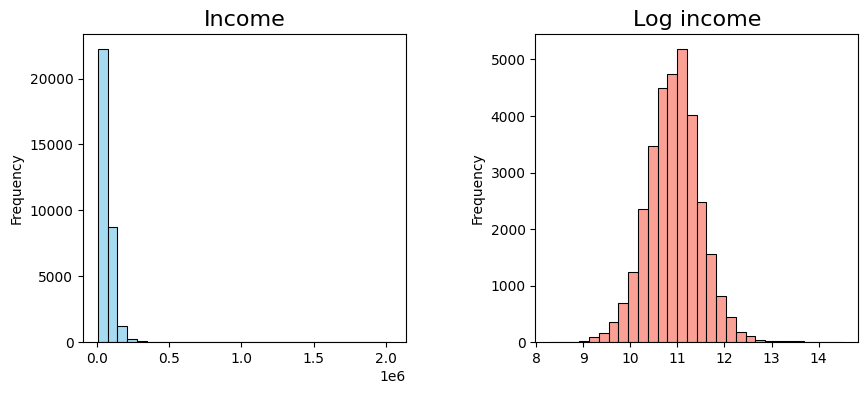

In [28]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(df0["person_income"], bins=30, kde=False, color='skyblue', edgecolor='black')
plt.title('Income', fontsize=16)
plt.ylabel('Frequency')
plt.xlabel('')
plt.subplot(1, 2, 2)
sns.histplot(np.log(df0["person_income"]), bins=30, kde=False, color='salmon', edgecolor='black')
plt.title('Log income', fontsize=16)
plt.ylabel('Frequency')
plt.xlabel('')
plt.subplots_adjust(wspace=0.4)
plt.show()

* All records are positive. It is safe to apply a logarithmic transformation.
* The distribution of personal income is heavily skewed. After applying a logarithmic transformation, the histogram no longer displays significant skewness.

In [29]:
# Check before doing log transformation
print(f"Are all records are positive?: {all(df0.loan_amnt > 0)}")

Are all records are positive?: True


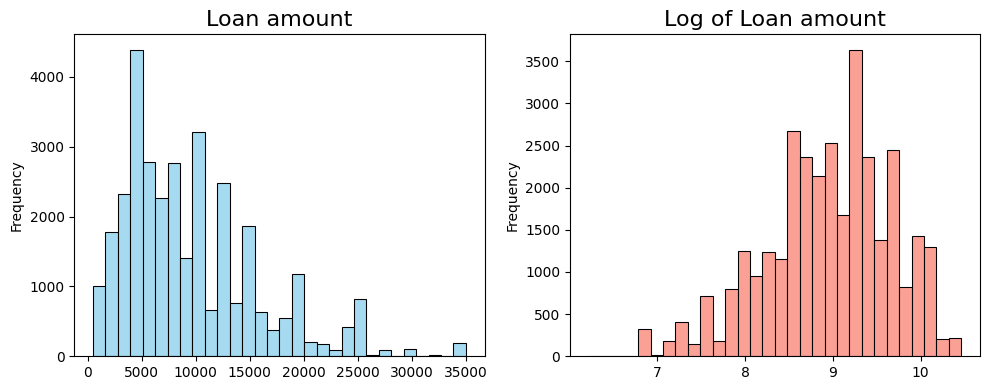

In [30]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(df0["loan_amnt"], bins=30, kde=False, color='skyblue', edgecolor='black')
plt.title('Loan amount', fontsize=16)
plt.ylabel('Frequency')
plt.xlabel('')
plt.subplot(1, 2, 2)
sns.histplot(np.log(df0["loan_amnt"]), bins=30, kde=False, color='salmon', edgecolor='black')
plt.title('Log of Loan amount', fontsize=16)
plt.ylabel('Frequency')
plt.xlabel('')
plt.tight_layout()
plt.show()

* All records are positive. It is safe to apply a logarithmic transformation.
* The logarithmic transformation moderately improved the skewness of the loan amount.

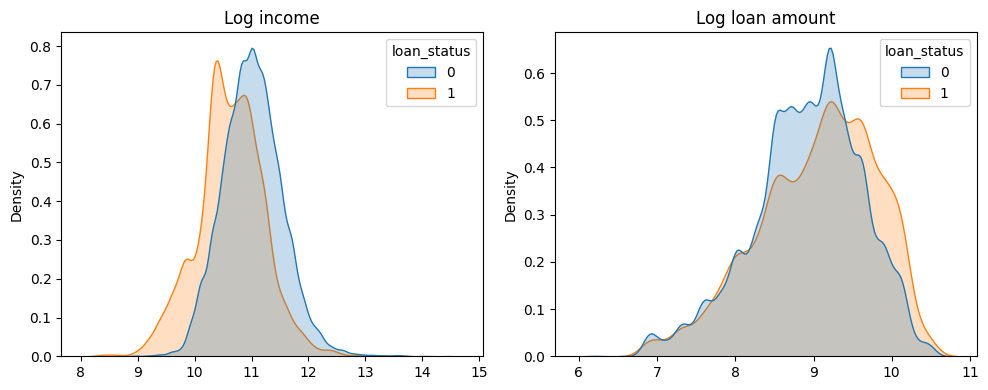

In [31]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.kdeplot(x=np.log(df0["person_income"]), hue='loan_status', data=df0, common_norm=False, fill=True)
plt.ylabel('Density')
plt.xlabel('')
plt.title("Log income")

plt.subplot(1, 2, 2)
sns.kdeplot(x=np.log(df0["loan_amnt"]), hue='loan_status', data=df0, common_norm=False, fill=True)
plt.ylabel('Density')
plt.xlabel('')
plt.title("Log loan amount")

plt.tight_layout()

plt.show()

* `log_loan_amnt`, `log_person_income` are helpful to distinguish borrowers' loan status.

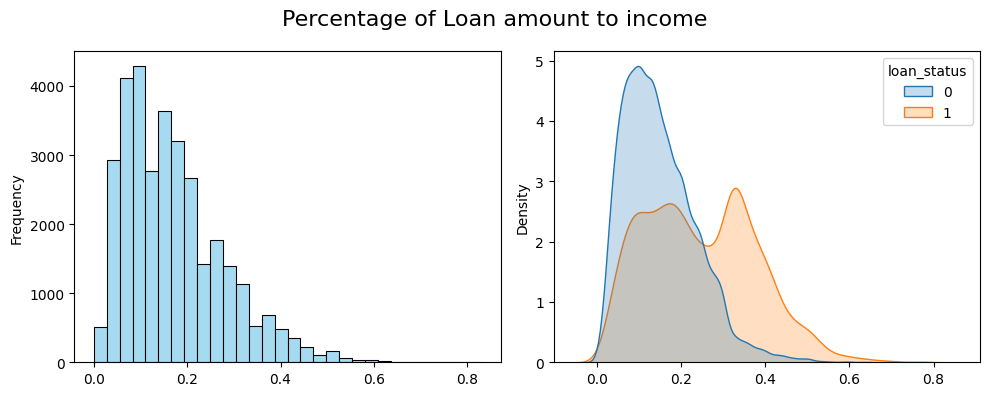

In [32]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(df0["loan_percent_income"], bins=30, kde=False, color='skyblue', edgecolor='black')
plt.ylabel('Frequency')
plt.xlabel('')

plt.subplot(1, 2, 2)
sns.kdeplot(x='loan_percent_income', hue='loan_status', data=df0, common_norm=False, fill=True)
plt.ylabel('Density')
plt.xlabel('')

plt.suptitle("Percentage of Loan amount to income", fontsize=16)
plt.tight_layout()

plt.show()

* The skewness of `loan_percent_income` is not serious, the log transformation was not performed.
* It is helpful to distinguish borrowers' loan status.

##### Interest rate

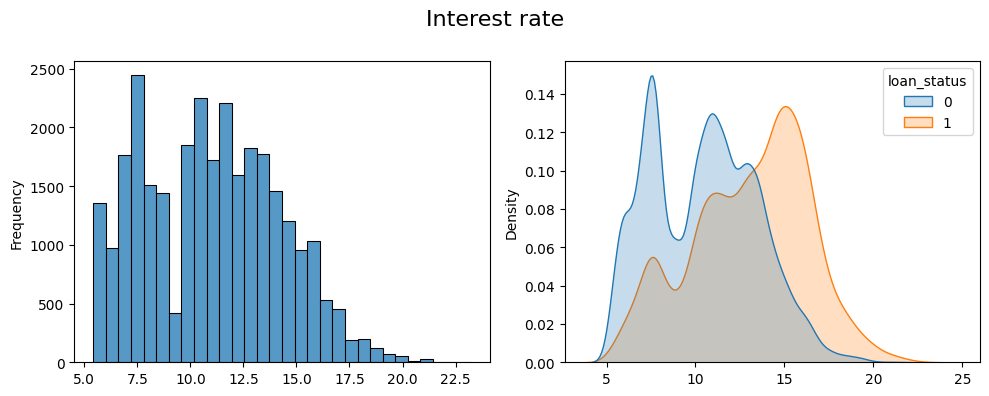

In [33]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(df0["loan_int_rate"], bins=30, kde=False, edgecolor='black')
plt.ylabel('Frequency')
plt.xlabel('')
plt.subplot(1, 2, 2)
sns.kdeplot(data=df0, x="loan_int_rate", hue="loan_status", fill=True, common_norm=False)
plt.xlabel('')
plt.tight_layout()
plt.suptitle("Interest rate", fontsize=16)
plt.subplots_adjust(top=0.85)
plt.show()

* The interest rate can be higher than 20%.
* Borrowers paying a higher loan rate is more likely to default
* It is expected that it can provide some help in classifying the loan status

##### Home owenership

In [34]:
def plot_cat(var, title):
    df = pd.crosstab(df0[var], df0["loan_status"], dropna=False, normalize="columns")
    fig, ax = plt.subplots(figsize=(10, 4))
    ax = df.plot.bar(rot=0,ax=ax)
    plt.xlabel("")
    plt.ylabel("Percentage normalised by Loan Status")
    plt.title(title, fontsize=16)
    ax.legend(loc='upper right')
    df_percentage = df.copy().rename(columns={0: "%0", 1: "%1"})
    df_n = pd.crosstab(df0[var], df0["loan_status"], dropna=False).rename(columns={0: "#0", 1: "#1"})
    df_table = pd.merge(df_n, df_percentage, left_index=True, right_index=True)
    df_table.loc["TOTAL"] = df_table.sum(axis=0)
    print(f"{df_table} \n * Percentage is normalised by columns i.e. the column sum is 1")

loan_status                 #0      #1        %0        %1
person_home_ownership                                     
MORTGAGE               11751.0  1690.0  0.461421  0.237794
OTHER                     74.0    33.0  0.002906  0.004643
OWN                     2391.0   193.0  0.093886  0.027156
RENT                   11251.0  5191.0  0.441787  0.730407
TOTAL                  25467.0  7107.0  1.000000  1.000000 
 * Percentage is normalised by columns i.e. the column sum is 1


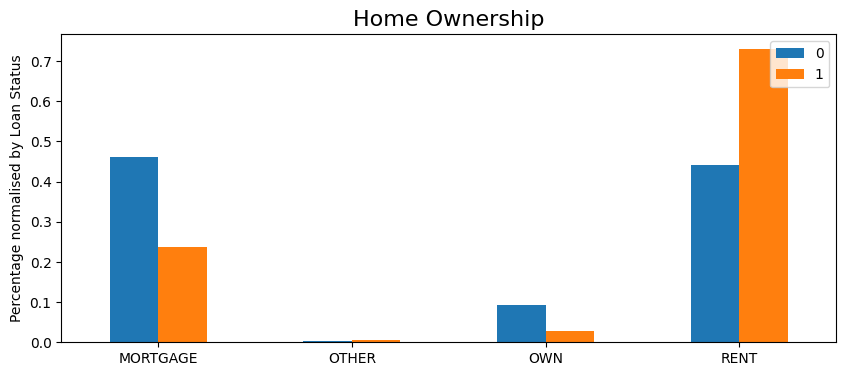

In [35]:
plot_cat("person_home_ownership", "Home Ownership")

* Rent has a higher percentage of default
* Merely a minute fraction of records (0.755%) fall under the category of 'OTHER,' and their interpretation poses a challenge

##### Loan intention

loan_status             #0      #1        %0        %1
loan_intent                                           
DEBTCONSOLIDATION   3722.0  1490.0  0.146150  0.209652
EDUCATION           5340.0  1111.0  0.209683  0.156325
HOMEIMPROVEMENT     2664.0   941.0  0.104606  0.132405
MEDICAL             4450.0  1621.0  0.174736  0.228085
PERSONAL            4422.0  1097.0  0.173636  0.154355
VENTURE             4869.0   847.0  0.191189  0.119178
TOTAL              25467.0  7107.0  1.000000  1.000000 
 * Percentage is normalised by columns i.e. the column sum is 1


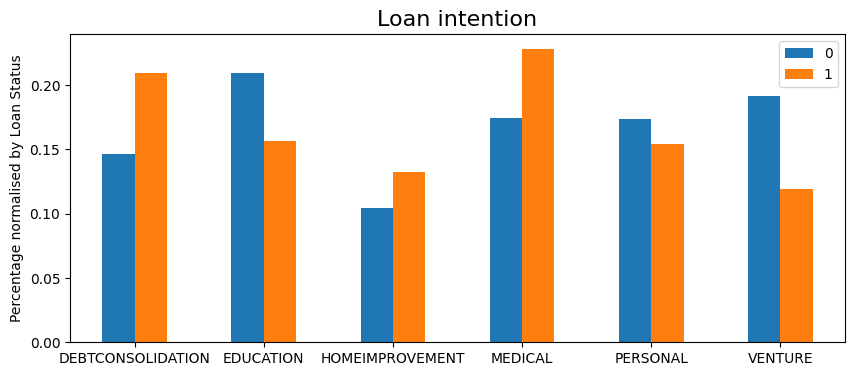

In [36]:
plot_cat("loan_intent", "Loan intention")

* The primary causes of default typically include debt consolidation, medical expenses, and home improvement

##### Loan Grade

loan_status       #0      #1        %0        %1
loan_grade                                      
A             9703.0  1073.0  0.381003  0.150978
B             8747.0  1701.0  0.343464  0.239341
C             5117.0  1339.0  0.200927  0.188406
D             1485.0  2140.0  0.058311  0.301112
E              343.0   621.0  0.013468  0.087379
F               71.0   170.0  0.002788  0.023920
G                1.0    63.0  0.000039  0.008864
TOTAL        25467.0  7107.0  1.000000  1.000000 
 * Percentage is normalised by columns i.e. the column sum is 1


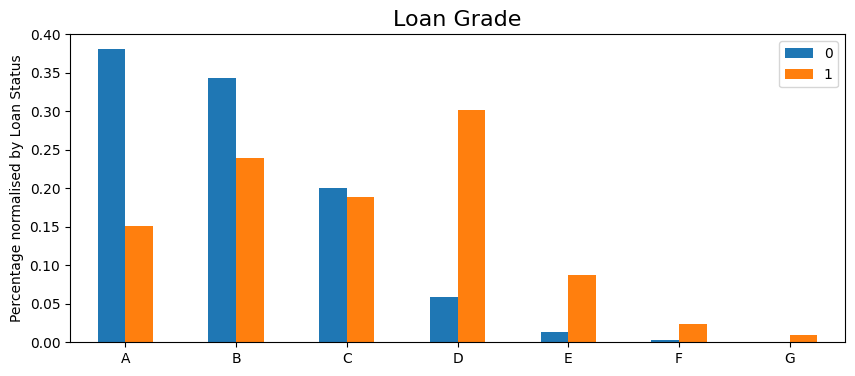

In [37]:
plot_cat("loan_grade", "Loan Grade")

* As the grade decreases, the chance of default increases

##### Historical default

loan_status                     #0      #1        %0        %1
cb_person_default_on_file                                     
N                          21894.0  4936.0  0.859701  0.694527
Y                           3573.0  2171.0  0.140299  0.305473
TOTAL                      25467.0  7107.0  1.000000  1.000000 
 * Percentage is normalised by columns i.e. the column sum is 1


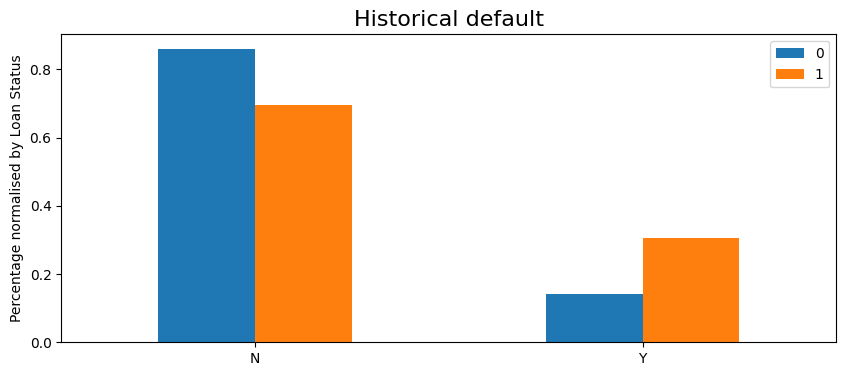

In [38]:
plot_cat("cb_person_default_on_file", "Historical default")

* Borrowers with a history of default are more likely to default again
* The relationship is not strong

#### Between features

##### Age vs Log income

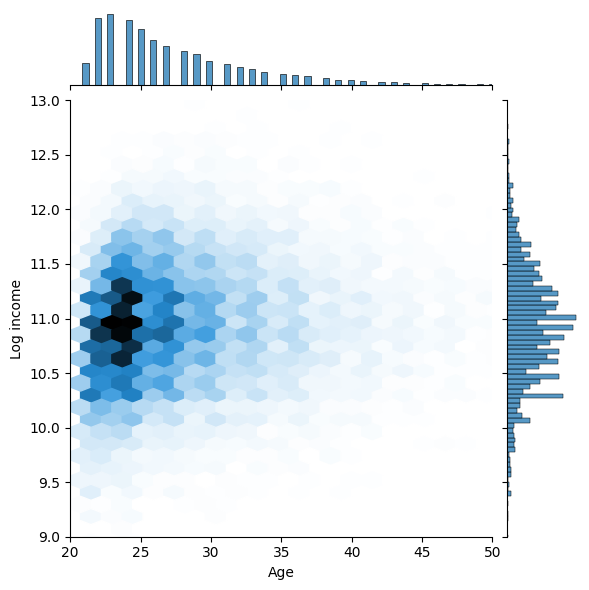

In [39]:
sns.jointplot(data=df0, x='person_age', y=np.log(df0["person_income"]), kind="hex", xlim=(20,50), ylim=(9,13))
plt.xlabel('Age')
plt.ylabel('Log income')
plt.show()

* There is no obvious relationship between age and log income

##### Age vs Loan intention

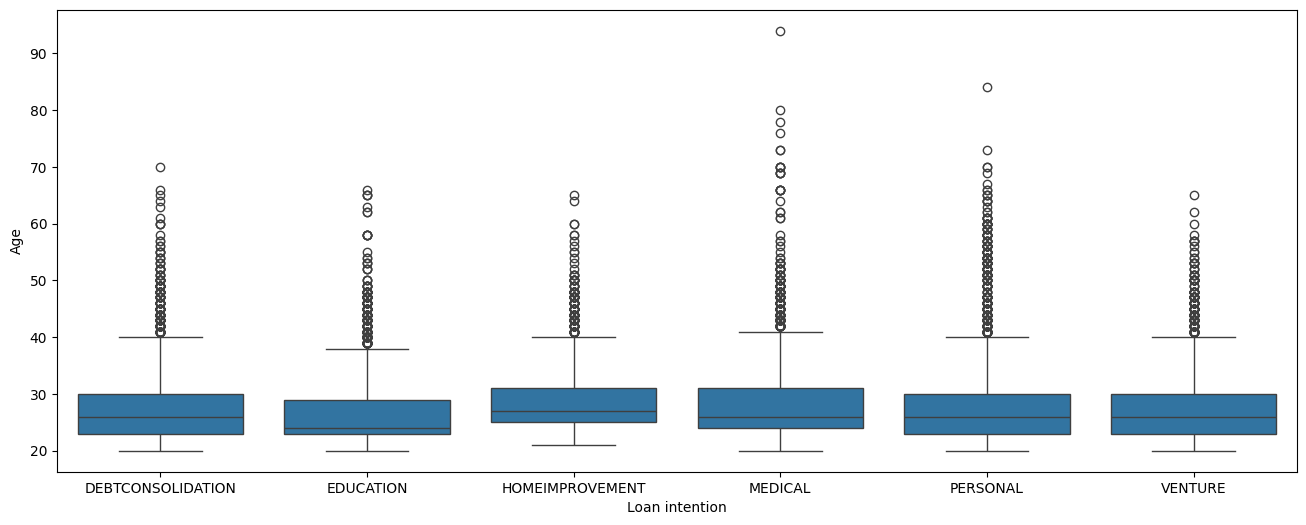

In [40]:
grade_order = sorted(df0['loan_intent'].unique())
plt.figure(figsize=(16, 6))
sns.boxplot(x="loan_intent", y="person_age", data=df0, order=grade_order)
plt.xlabel("Loan intention")
plt.ylabel("Age")
plt.show()

* The mean age for the intention of taking out a loan for education is the lowest. Generally, the mean ages between groups are close.

##### Age vs Credit history length

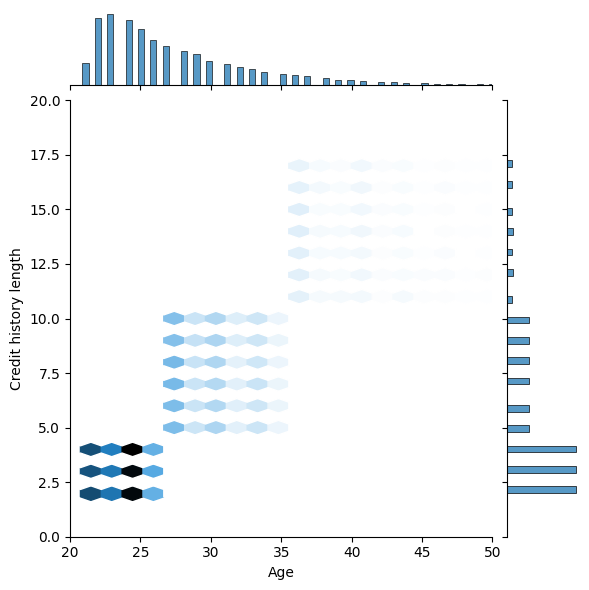

In [41]:
sns.jointplot(data=df0, x='person_age', y='cb_person_cred_hist_length', kind="hex", xlim=(20, 50), ylim=(0, 20))
plt.xlabel('Age')
plt.ylabel('Credit history length')
plt.show()

* The length of the credit history increases as the age of the borrowers increase

##### Employment length and log income

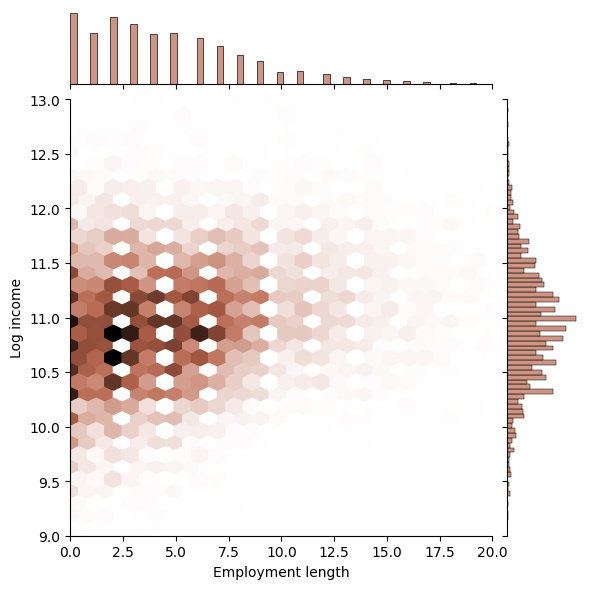

In [42]:
sns.jointplot(data=df0, x='person_emp_length', y=np.log(df0["person_income"]), kind="hex", xlim=(0, 20), ylim=(9, 13), color="#BE725B")
plt.xlabel('Employment length')
plt.ylabel('Log income')
plt.show()

* As the employment length increases, the log income also rises

##### Historical default vs Interest rate of loan

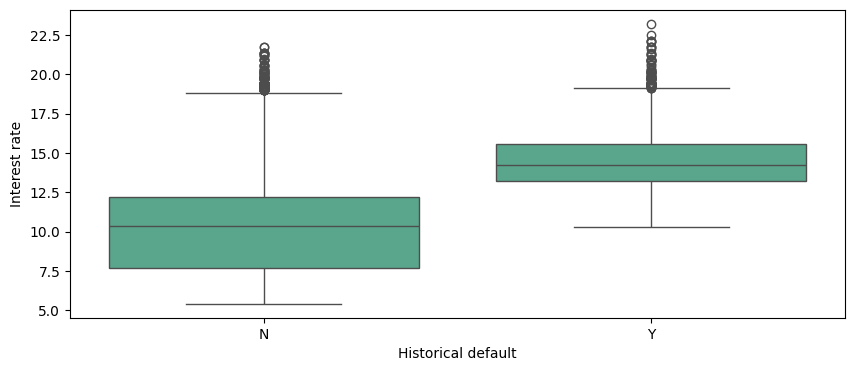

In [43]:
grade_order = sorted(df0['cb_person_default_on_file'].unique())
plt.figure(figsize=(10, 4))
sns.boxplot(x="cb_person_default_on_file", y="loan_int_rate", data=df0, order=grade_order, color="#4CB391")
plt.xlabel("Historical default")
plt.ylabel("Interest rate")
plt.show()

* Borrowers with a historical default need to pay a higher interest rate for the loan

##### Credit history length vs Loan interest rate

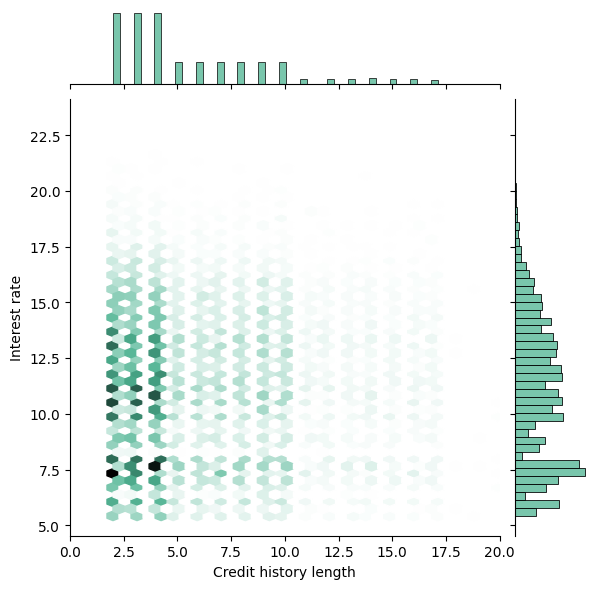

In [44]:
sns.jointplot(data=df0, x="cb_person_cred_hist_length", y="loan_int_rate", kind="hex", color="#4CB391",xlim=(0, 20))
plt.xlabel("Credit history length")
plt.ylabel("Interest rate")
plt.show()

* The longer the credit history length, the lower the interest rate

### Data Transformation
1. Perform Logarithmic Transformation to `person_income` and `loan_amnt`
2. Remove 107 rows in which `person_home_ownership` is "OTHER"

In [70]:
df0["log_person_income"] = np.log(df0.person_income)
df0["log_loan_amnt"] = np.log(df0.loan_amnt)
rows = (df0.person_home_ownership == "OTHER")
columns = ["person_income", "loan_amnt"]
df = df0[~rows].drop(columns, axis=1)

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32467 entries, 1 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32467 non-null  int64  
 1   person_home_ownership       32467 non-null  object 
 2   person_emp_length           31572 non-null  float64
 3   loan_intent                 32467 non-null  object 
 4   loan_grade                  32467 non-null  object 
 5   loan_int_rate               29365 non-null  float64
 6   loan_status                 32467 non-null  int64  
 7   loan_percent_income         32467 non-null  float64
 8   cb_person_default_on_file   32467 non-null  object 
 9   cb_person_cred_hist_length  32467 non-null  int64  
 10  log_person_income           32467 non-null  float64
 11  log_loan_amnt               32467 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 3.2+ MB


### Model fitting

In [72]:
random_seed = 42

#### Include more features

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32467 entries, 1 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32467 non-null  int64  
 1   person_home_ownership       32467 non-null  object 
 2   person_emp_length           31572 non-null  float64
 3   loan_intent                 32467 non-null  object 
 4   loan_grade                  32467 non-null  object 
 5   loan_int_rate               29365 non-null  float64
 6   loan_status                 32467 non-null  int64  
 7   loan_percent_income         32467 non-null  float64
 8   cb_person_default_on_file   32467 non-null  object 
 9   cb_person_cred_hist_length  32467 non-null  int64  
 10  log_person_income           32467 non-null  float64
 11  log_loan_amnt               32467 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 3.2+ MB



* **Age** only indirectly affects the risk of default. It is believed that the older individuals have more stable incomes and established careers, but in this dataset, such relationship cannot be discovered. Older individuals have a longer credit history, which provides more data for lenders to evaluate their creditworthiness. 
* **Income** measures a borrower's ability to make timely loan payments. Higher income levels indicate a greater capacity to meet financial commitments, i.e., a lower chance of default
* **Home ownership** is not a good indicator because renting doesn't necessarily indicate financial instability. Some individuals, especially in certain life stages or regions, prefer renting for flexibility although owing a home indicate financial stability and a long-term commitment to a particular residence
* As the **employment length** increases, the income also rises. However, it does not have strong predictive power
* Loan with different **intention** carry varying levels of risk. For example, Educational or business investments may have the potential to generate income and improve the borrower's financial situation, while loans for debit consolidation and medical purposes might be seen as higher risk
* **Grade** represents the risk of default. It has a strong predictive power.
* The **loan amount** contributes to the borrower's overall debt burden. If the loan amount is high relative to the borrower's income, it may increase the risk of default, especially if the borrower struggles to meet the resulting monthly payments
* **Interest rate** is a significant factor in determining the overall cost of borrowing and can impact the likelihood of default. Higher interest rates lead to higher monthly payments, making it potentially more challenging for borrowers to afford their loan obligations. If the interest rate is too high relative to the borrower's income, it increases the risk of default.
* It is common to calculate **the ratio of loan amount to income** i.e. debt-to-income ratio (DTI). A lower DTI suggests that the borrower has more income available to meet new financial obligations, making them a lower credit risk
* **Historical default** suggests a pattern of financial behavior that includes difficulties in meeting financial obligations. A person with a history of default has a higher risk of default
* A longer **credit history length** provides more data points for lenders to assess a person's financial behaviour. Therefore, it may not have strong predictive power.

In [74]:
columns = ['loan_intent', 'loan_grade', 'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file', 'log_person_income', 'log_loan_amnt']
X, y = df[columns].copy(), df[["loan_status"]].copy()
cats = X.select_dtypes(exclude=np.number).columns.tolist()
for col in cats:
   X[col] = X[col].astype('category')
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32467 entries, 1 to 32580
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   loan_intent                32467 non-null  category
 1   loan_grade                 32467 non-null  category
 2   loan_int_rate              29365 non-null  float64 
 3   loan_percent_income        32467 non-null  float64 
 4   cb_person_default_on_file  32467 non-null  category
 5   log_person_income          32467 non-null  float64 
 6   log_loan_amnt              32467 non-null  float64 
dtypes: category(3), float64(4)
memory usage: 1.3 MB


#### Data partition

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed, stratify=y)

In [76]:
print(f"For training set, the ratio of default to non-default: {(y_train.sum() / len(y_train)).values[0]}")
print(f"For testing set, the ratio of default to non-default: {(y_test.sum() / len(y_test)).values[0]}")

For training set, the ratio of default to non-default: 0.21788010626419743
For testing set, the ratio of default to non-default: 0.21789344009855252


#### Handle imbalance

In [77]:
weight = y_train.value_counts()
weight = weight[0]/weight[1]
print(f"Class imbalance ratio: {weight}")

Class imbalance ratio: 3.589680155504506


#### Model tuning

In [78]:
param_grid = {
    "learning_rate": [0.0001, 0.001, 0.01, 0.1, 1],
    "gamma": [0, 0.1, 0.5, 1, 5, 10],
    "reg_lambda": [0, 1, 5, 10, 20, 50]
}

In [79]:
xgb_clf3 = xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=weight, validate_parameters=True, enable_categorical=True, random_state=random_seed, colsample_bytree=0.5)
optimal_params = GridSearchCV(estimator=xgb_clf3, param_grid=param_grid, scoring='roc_auc', verbose=1, cv=3)

In [80]:
optimal_params.fit(X=X_train, y=y_train)

Fitting 3 folds for each of 180 candidates, totalling 540 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.5, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=True, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, ma...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'gamma': [0, 0.1, 0.5, 1, 5, 10],
                         'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1],
                         'reg_lambda': [0, 1, 5, 10, 20, 50]},
             scoring='roc_auc', verbose=1)

In [81]:
optimal_params.best_params_

{'gamma': 1, 'learning_rate': 0.1, 'reg_lambda': 0}

In [82]:
y_pred_train = optimal_params.predict(X_train)
y_predict_proba_train = optimal_params.predict_proba(X_train)[:,1]
y_pred_test = optimal_params.predict(X_test)
y_predict_proba_test = optimal_params.predict_proba(X_test)[:,1]

In [83]:
auc3_train = roc_auc_score(y_train, y_predict_proba_train)
auc3_test = roc_auc_score(y_test, y_predict_proba_test)
f1_score3_train = f1_score(y_train, y_pred_train)
f1_score3_test = f1_score(y_test, y_pred_test)

In [84]:
print(f"training AUC is {auc3_train}")
print(f"training F1 score is {f1_score3_train}")

training AUC is 0.9402668743943275
training F1 score is 0.752872633112154


In [85]:
print(f"testing AUC is {auc3_test}")
print(f"testing F1 score is {f1_score3_test}")

testing AUC is 0.910848035665461
testing F1 score is 0.7147944318549693
